In [1]:
%matplotlib inline
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import mio
import os, glob, random

In [2]:
def is_valid(GeoSeries):
    for geom in GeoSeries:
        assert geom.is_valid
        if geom.type not in ['Polygon','MultiPolygon']:
            print('geometry is', geom.type, "expected Polygon")
            assert False

In [3]:
def cutpoint(p1:tuple, p2:tuple)->tuple:
    "calc point cuts zero plane"
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if (z2 - z1) != 0:
        k = - z1 / (z2 - z1)
    else:
        k = 0
    x0 = x1 + k * (x2 - x1)
    y0 = y1 + k * (y2 - y1)
    z0 = z1 + k * (z2 - z1)
    return x0, y0, z0

In [4]:
def slice_line(p1:tuple, p2:tuple)->list:
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if z1>0 and z2>0:
        # line above zero plane
        return [(x1, y1, 0), (x2, y2, 0)]
    if z1<0 and z2<0:
        # Line below zero plane
        return []
    p0 = cutpoint(p1, p2)
    if z1<=0:
        # replace first point
        return [p0, p2]
    if z2<=0:
        # replace second point
        return [p1, p0]

In [5]:
def slice_tri(poly:Polygon, h:float, tri_buffer:float):
    " Slice one triangle"
    p1 =   poly.exterior.coords[0]
    p2 =   poly.exterior.coords[1]
    p3 =   poly.exterior.coords[2]
    p1 = [p1[0], p1[1], p1[2]-h]
    p2 = [p2[0], p2[1], p2[2]-h]
    p3 = [p3[0], p3[1], p3[2]-h]
    l = []
    l1 = slice_line(p1, p2)
    l2 = slice_line(p2, p3)
    l3 = slice_line(p3, p1)
    l = l1 + l2 + l3
    # aribitrary buffer to avoid topology errors (1 cm!)
    poly = Polygon(l).buffer(tri_buffer)
    if poly.area == 0:
        return
    
    return poly

In [6]:
def make_level(tri, h, tri_buffer):
    pl = []
    for t in tri:
        poly = Polygon(t)
        poly = slice_tri(poly, h, tri_buffer)
        if poly is not None:   # avoid empty polygons
            pl.append(poly)
    gdf = gpd.GeoDataFrame(geometry=pl)
    
    # try to fix topolgy array
    gdf.geometry = gdf.geometry.buffer(0)
    
    #is_valid(gdf.geometry)
    gdf['id'] = 1
    gdf = gdf.dissolve('id')
    return gdf.geometry[1]

In [7]:
def read_obj_file(model_path:str)->tuple:
    # read obj file
    fin = open(model_path)
    v_list = []
    f_list = []
    for s in fin:
        l = s.split()
        if l[0] == 'g':
            lon = float(l[1])
            lat = float(l[2])
        if l[0] == 'v':
            vertex = float(l[1]), float(l[2]),float(l[3])
            v_list.append(vertex)                                    
        if l[0] == 'f':
            poi = l[1:]
            poi = [int(x)-1 for x in poi]
            f_list.append(poi)
    return v_list, f_list, lon, lat

In [8]:
def resolve_tris(v_list:list, f_list:list)->list:
    tris = []
    for f in f_list:
        tri = [v_list[p] for p in f]
        tris.append(tri)
    return tris

In [9]:
def get_hight_range(tris:list)->tuple:
    h_min = 8848
    h_max = 0
    for tri in tris:
        for point in tri:
            h = point[2]
            if h > h_max: h_max = h
            if h < h_min: h_min = h
    return h_min, h_max

In [10]:
def levels_df(tris:list, tri_buffer:float, min_dif:float) -> gpd.GeoDataFrame:
    h_min, h_max = get_hight_range(tris)
    h_min = int(h_min-1)
    h_max = int(h_max+1)
    gl = []
    area = 0
    for h in range(h_min, h_max):
        row = {}
        row['h'] = h
        geom =  make_level(tris, h, tri_buffer)
        ar = geom.area
        row['geometry'] = geom
        if abs(ar - area) > min_dif and ar>min_dif:
            gl.append(row)
            area = ar
    gdf = gpd.GeoDataFrame(gl)
    gdf = gdf.iloc[::-1]
    gdf = gdf.reset_index(drop=True)
    return gdf.copy()

In [11]:
def make_v_f(row:gpd.GeoSeries)->list:
    v_list = []
    f_list = []
    i = 0
    for coord in row.geometry.exterior.coords:
        i += 1
        xyz = (coord[0], coord[1], row.h)
        v_list.append(xyz)
        f_list.append(i)
    return v_list, f_list

In [12]:
def write_level_obj(gdf:gpd.GeoDataFrame, obj_dest:str):
    fout = open(obj_dest, 'w')
    fout.write('g\n')
    i_offset = 0
    for ind, row in gdf[:].iterrows():
        v_list, f_list = make_v_f(row)
        for coord in v_list:
            s = "v %f %f %f\n" % coord
            fout.write(s)
        sv = 'f '
        for i in f_list:
            sv = sv + " " + str(i + i_offset)
        fout.write(sv + "\n")
        i_offset += len(f_list)
    fout.close()

In [13]:
def cut_out(gdf:gpd.GeoDataFrame, cut_buffer:float):
    gdf = gdf.copy()
    gdf.geometry = gdf.geometry.buffer(0)
    gdf.geometry = [geom for geom in gdf.geometry if geom.area>1]
    for i in range(len(gdf)-1):
        upper = gdf.geometry.iloc[0:i+1]
        #is_valid(upper)
        
        lower = gdf.geometry.iloc[i+1:]
        #is_valid(lower)
        
        geom = upper.unary_union.buffer(cut_buffer)
        #assert geom.is_valid
        
        # try to decrease topologyerrors by buffering
        lower_cut = lower.buffer(0).difference(geom)

        
        lower_cut = lower_cut.buffer(0)
        #is_valid(lower_cut)
               
        res = upper.append(lower_cut)
        gdf.geometry = res
        gdf.geometry.buffer(0)
    return gdf

In [14]:
def obj_to_json(model_path:str, dest:str)->gpd.GeoDataFrame:
    v_list, f_list, lon, lat = read_obj_file(model_path)
    tris = resolve_tris(v_list, f_list)
    gdf = levels_df(tris, tri_buffer=0.003, min_dif=1)
    gdf = cut_out(gdf, cut_buffer=0.003)
    gdf = mio.disagg(gdf)
    gdf.geometry = gdf.geometry.buffer(0)
    gdf['lon'] = lon
    gdf['lat'] = lat
    gdf['model_path'] = model_path
    gdf.to_file(dest, driver="GeoJSON")
    return gdf

In [15]:
%%time
fl = glob.glob('json/1091/*.obj')
print('files', len(fl))
for i, obj_file in enumerate(fl):
    mio.show_perc(i, len(fl), 50)
    dest = os.path.splitext(obj_file)[0] + '.json'
    if not os.path.isfile(dest):
        try:
            gdf = obj_to_json(obj_file, dest)
        except:
            print("Error", obj_file)

files 95629
0.0% 0.05% 0.1% 0.16% 0.21% 0.26% 0.31% 0.37% 0.42% 0.47% 0.52% 0.58% 0.63% 0.68% 0.73% 0.78% 0.84% 0.89% 0.94% 0.99% 1.05% 1.1% 1.15% 1.2% 1.25% 1.31% 1.36% 1.41% 1.46% 1.52% 1.57% 1.62% 1.67% 1.73% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 5.5182598656695605 -0.61955098235936301 at 5.5182598656695605 -0.61955098235936301


Error json/1091\1091-11_model_2524.obj
1.78% 1.83% 1.88% 1.93% 1.99% 2.04% 2.09% 2.14% 2.2% 2.25% 2.3% 2.35% 2.41% 2.46% 2.51% 2.56% 2.61% 2.67% 2.72% 2.77% 2.82% 2.88% 2.93% 2.98% 3.03% 3.08% 3.14% 

TopologyException: Input geom 1 is invalid: Nested shells at or near point 7.3137487646821855 -5.3430322858544859 at 7.3137487646821855 -5.3430322858544859


Error json/1091\1091-11_model_3722.obj
3.19% 3.24% 3.29% 3.35% 3.4% 3.45% 3.5% 3.56% 3.61% 3.66% 3.71% 3.76% 3.82% 3.87% 3.92% 3.97% 4.03% 4.08% 4.13% 4.18% 4.24% Error json/1091\1091-12_model_102.obj
4.29% 4.34% 4.39% 4.44% 4.5% Error json/1091\1091-12_model_122.obj
4.55% 4.6% 4.65% 4.71% 4.76% 4.81% 4.86% 4.91% 4.97% 5.02% 5.07% 5.12% 5.18% 5.23% 5.28% 5.33% 5.39% 5.44% 5.49% 5.54% 5.59% 5.65% 5.7% 5.75% 5.8% 5.86% 5.91% 5.96% 6.01% 6.07% 6.12% 6.17% 6.22% 6.27% 6.33% 6.38% 6.43% 6.48% 6.54% 6.59% 6.64% 6.69% 6.74% 6.8% 6.85% 6.9% 6.95% 7.01% 7.06% 7.11% 7.16% 7.22% 7.27% 7.32% 7.37% 7.42% 7.48% 7.53% 7.58% 7.63% 7.69% 7.74% 7.79% 7.84% 7.9% 7.95% 8.0% 8.05% 8.1% 8.16% 8.21% 8.26% 8.31% 8.37% 8.42% 8.47% 8.52% 8.57% 8.63% 8.68% 8.73% 8.78% 8.84% 8.89% 8.94% 8.99% 9.05% 9.1% 9.15% 9.2% 9.25% 9.31% 9.36% 9.41% 9.46% 9.52% 9.57% 9.62% 9.67% 9.73% 9.78% 9.83% 9.88% 9.93% 9.99% 10.04% 10.09% 10.14% 10.2% 10.25% 10.3% 10.35% 10.4% 10.46% 10.51% 10.56% 10.61% 10.67% 10.72% 10.77% 10.82% 10.

TopologyException: Input geom 1 is invalid: Nested shells at or near point 3.3813867271926643 -3.5623697180004275 at 3.3813867271926643 -3.5623697180004275


Error json/1091\1091-13_model_5431.obj
13.8% 13.86% 13.91% 13.96% 14.01% 14.06% 14.12% 14.17% 14.22% 14.27% 14.33% 14.38% 14.43% 14.48% 14.54% 14.59% 14.64% 14.69% 14.74% 14.8% 14.85% 14.9% 14.95% 15.01% 15.06% 15.11% 15.16% 15.22% 15.27% 15.32% 15.37% 15.42% 15.48% 15.53% 15.58% 15.63% 15.69% 15.74% 15.79% 15.84% 15.89% 15.95% 16.0% 16.05% 16.1% 16.16% 16.21% 16.26% 16.31% Error json/1091\1091-14_model_2358.obj
16.37% 16.42% 16.47% 16.52% 16.57% 16.63% 16.68% 16.73% 16.78% 16.84% 16.89% 16.94% 16.99% 17.05% 17.1% 17.15% 17.2% 17.25% 17.31% 17.36% 17.41% 17.46% 17.52% 17.57% 17.62% 17.67% 17.72% 17.78% 17.83% 17.88% 17.93% 17.99% 18.04% 18.09% Error json/1091\1091-14_model_3922.obj
18.14% 18.2% 18.25% 18.3% 18.35% 18.4% 18.46% 18.51% 18.56% 18.61% 18.67% 18.72% 18.77% 18.82% 18.88% 18.93% 18.98% 19.03% 19.08% 19.14% 19.19% 19.24% 19.29% 19.35% 19.4% Error json/1091\1091-14_model_5022.obj
19.45% 19.5% 19.55% 19.61% 19.66% 19.71% 19.76% 19.82% 19.87% 19.92% 19.97% 20.03% 20.08% 20.13% 20

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.14711111597287491 -3.4652082185265156 at -0.14711111597287491 -3.4652082185265156


Error json/1091\1091-22_model_3252.obj
34.3% 34.35% 34.4% 34.46% 34.51% 34.56% 34.61% 34.67% 34.72% 34.77% 34.82% 34.87% 34.93% 34.98% 35.03% 35.08% 35.14% 35.19% 35.24% 35.29% 35.34% 35.4% 35.45% 35.5% 35.55% 35.61% 35.66% 35.71% 35.76% 35.82% 35.87% 35.92% 35.97% 36.02% 36.08% 36.13% 36.18% 36.23% 36.29% 36.34% 36.39% 36.44% 36.5% 36.55% 36.6% 36.65% 36.7% 36.76% 36.81% 36.86% 36.91% 36.97% 37.02% 37.07% 37.12% 37.17% 37.23% 37.28% 37.33% 37.38% 37.44% 37.49% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.60444868327309176 -3.2016110249046728 at -0.60444868327309176 -3.2016110249046728


Error json/1091\1091-22_model_6035.obj


TopologyException: Input geom 1 is invalid: Self-intersection at or near point 7.8178816501188608 0.034062923860477295 at 7.8178816501188608 0.034062923860477295


Error json/1091\1091-22_model_6038.obj
37.54% 37.59% 37.65% 37.7% 37.75% 37.8% 37.85% 37.91% 37.96% 38.01% 38.06% 38.12% 38.17% 38.22% 38.27% 38.33% 38.38% 38.43% 38.48% 38.53% 38.59% 38.64% 38.69% 38.74% 38.8% 38.85% 38.9% 38.95% 39.0% 39.06% 39.11% 39.16% 39.21% 39.27% 39.32% 39.37% 39.42% 39.48% 39.53% 39.58% 39.63% 39.68% 39.74% 39.79% 39.84% 39.89% 39.95% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.9696044367448966 17.209388101011424 at -0.9696044367448966 17.209388101011424


Error json/1091\1091-23_model_1119.obj
40.0% 40.05% 40.1% 40.16% 40.21% 40.26% 40.31% 40.36% 40.42% 40.47% 40.52% 40.57% 40.63% 40.68% 40.73% 40.78% 40.83% 40.89% 40.94% 40.99% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 0.4230048111603783 1.6968695419924655 at 0.4230048111603783 1.6968695419924655


Error json/1091\1091-23_model_2004.obj
41.04% 41.1% 41.15% 41.2% 41.25% 41.31% 41.36% 41.41% 41.46% 41.51% 41.57% 41.62% 41.67% 41.72% 41.78% 41.83% 41.88% 41.93% 41.99% 42.04% 42.09% 42.14% 42.19% 42.25% 42.3% 42.35% 42.4% 42.46% 42.51% 42.56% 42.61% 42.66% 42.72% 42.77% 42.82% 42.87% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 0.019205253373673077 4.1900073543752603 at 0.019205253373673077 4.1900073543752603


Error json/1091\1091-23_model_3644.obj
42.93% 42.98% 43.03% 43.08% 43.14% 43.19% 43.24% 43.29% 43.34% 43.4% Error json/1091\1091-23_model_4104.obj
43.45% 43.5% 43.55% 43.61% 43.66% 43.71% 43.76% 43.82% 43.87% 43.92% 43.97% 44.02% 44.08% 44.13% 44.18% 44.23% 44.29% 44.34% 44.39% 44.44% 44.49% 44.55% 44.6% 44.65% 44.7% 44.76% 44.81% 44.86% 44.91% 44.97% 45.02% 45.07% 45.12% 45.17% 45.23% 45.28% 45.33% 45.38% 45.44% 45.49% 45.54% 45.59% 45.65% 45.7% 45.75% 45.8% 45.85% 45.91% 45.96% 46.01% 46.06% 46.12% 46.17% 46.22% 46.27% 46.32% 46.38% 46.43% 46.48% 46.53% 46.59% 46.64% 46.69% 46.74% 46.8% 46.85% 46.9% 46.95% 47.0% 47.06% 47.11% 47.16% 47.21% 47.27% 47.32% 47.37% 47.42% 47.48% 47.53% 47.58% 47.63% 47.68% 47.74% 47.79% 47.84% 47.89% 47.95% 48.0% 48.05% 48.1% 48.15% 48.21% 48.26% 48.31% 48.36% 48.42% 48.47% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 2.5695312395856584 0.23443367596884132 at 2.5695312395856584 0.23443367596884132


Error json/1091\1091-23_model_8443.obj
48.52% 48.57% 48.63% 48.68% 48.73% 48.78% 48.83% 48.89% 48.94% 48.99% 49.04% 49.1% 49.15% 49.2% 49.25% 49.31% 49.36% 49.41% 49.46% 49.51% 49.57% 49.62% 49.67% 49.72% 49.78% 49.83% 49.88% 49.93% 49.98% 50.04% 50.09% 50.14% 50.19% 50.25% 50.3% 50.35% 50.4% 50.46% 50.51% 50.56% 50.61% 50.66% 50.72% 50.77% 50.82% 50.87% 50.93% 50.98% 51.03% 51.08% 51.14% 51.19% 51.24% 51.29% 51.34% 51.4% 51.45% 51.5% 51.55% 51.61% 51.66% 51.71% 51.76% 51.81% 51.87% 51.92% 51.97% 52.02% 52.08% 52.13% 52.18% 52.23% 52.29% 52.34% 52.39% 52.44% 52.49% 52.55% 52.6% 52.65% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 5.6195612885373558 -0.67540980516950244 at 5.6195612885373558 -0.67540980516950244


Error json/1091\1091-24_model_3435.obj
52.7% 52.76% 52.81% 52.86% 52.91% 52.97% 53.02% 53.07% 53.12% 53.17% 53.23% 53.28% 53.33% 53.38% 53.44% 53.49% 53.54% 53.59% 53.64% 53.7% 53.75% 53.8% 53.85% 53.91% 53.96% 54.01% 54.06% 54.12% 54.17% 54.22% 54.27% 54.32% 54.38% 54.43% 54.48% 54.53% 54.59% 54.64% 54.69% 54.74% 54.8% 54.85% 54.9% 54.95% 

TopologyException: Input geom 1 is invalid: Nested shells at or near point -2.7709232871620477 -3.4729934049011004 at -2.7709232871620477 -3.4729934049011004


Error json/1091\1091-24_model_5433.obj
55.0% 55.06% 55.11% 55.16% 55.21% 55.27% 55.32% 55.37% 55.42% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.91919230983333755 5.3827462302012066 at -0.91919230983333755 5.3827462302012066


Error json/1091\1091-24_model_5823.obj
55.47% 55.53% 55.58% 55.63% 55.68% 55.74% 55.79% 55.84% 55.89% 55.95% 56.0% 56.05% 56.1% 56.15% 56.21% 56.26% 56.31% 56.36% 56.42% 56.47% 56.52% 56.57% 56.63% 56.68% 56.73% 56.78% 56.83% 56.89% 56.94% 56.99% 57.04% 57.1% 57.15% 57.2% 57.25% 57.3% 57.36% 57.41% 57.46% 57.51% 57.57% 57.62% 57.67% 57.72% 57.78% 57.83% 57.88% 57.93% 57.98% 58.04% 58.09% 58.14% 58.19% 58.25% 58.3% 58.35% 58.4% 58.46% 58.51% 58.56% 58.61% 58.66% 58.72% 58.77% 58.82% 58.87% 58.93% 58.98% 59.03% 59.08% 59.13% 59.19% 59.24% 59.29% 59.34% 59.4% 59.45% 59.5% 59.55% 59.61% 59.66% 59.71% 59.76% 59.81% 59.87% 59.92% 59.97% 60.02% 60.08% 60.13% 60.18% 60.23% 60.29% 60.34% 60.39% 60.44% 60.49% 60.55% 60.6% 60.65% 60.7% 60.76% 60.81% 60.86% 60.91% 60.96% 61.02% 61.07% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4.5765264643116126 -2.9244013909244391 at 4.5765264643116126 -2.9244013909244391


Error json/1091\1091-32_model_3653.obj
61.12% 61.17% 61.23% 61.28% 61.33% 61.38% 61.44% 61.49% 61.54% 61.59% 61.64% 61.7% 61.75% 61.8% 61.85% 61.91% 61.96% 62.01% 62.06% 62.12% 62.17% 62.22% 62.27% 62.32% 62.38% 62.43% 62.48% 62.53% 62.59% 62.64% 62.69% 62.74% 62.79% 62.85% 62.9% 62.95% 63.0% 63.06% 63.11% 63.16% 63.21% 63.27% 63.32% 63.37% 63.42% 63.47% 63.53% 63.58% 63.63% 63.68% 63.74% 63.79% 63.84% 63.89% 63.95% 64.0% 64.05% 64.1% Error json/1091\1091-32_model_665.obj
64.15% 64.21% 64.26% 64.31% 64.36% 64.42% 64.47% 64.52% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -4.6002114833824228 0.23082081881159591 at -4.6002114833824228 0.23082081881159591


Error json/1091\1091-32_model_995.obj
64.57% 64.62% 64.68% 64.73% 64.78% 64.83% 64.89% 64.94% 64.99% 65.04% 65.1% 65.15% 65.2% 65.25% 65.3% 65.36% 65.41% 65.46% 65.51% 65.57% 65.62% 65.67% 65.72% 65.78% 65.83% 65.88% 65.93% 65.98% 66.04% 66.09% 66.14% 66.19% 66.25% 66.3% 66.35% 66.4% 66.45% 66.51% 66.56% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.3666154214605537 5.3469840456004469 at -0.3666154214605537 5.3469840456004469


Error json/1091\1091-34_model_1203.obj
66.61% 66.66% 66.72% 66.77% 66.82% 66.87% 66.93% 66.98% 67.03% 67.08% 67.13% 67.19% 67.24% 67.29% 67.34% 67.4% 67.45% 67.5% 67.55% 67.61% 67.66% 67.71% 67.76% 67.81% 67.87% 67.92% 67.97% 68.02% 68.08% 68.13% 68.18% 68.23% 68.28% 68.34% 68.39% 68.44% 68.49% 68.55% 68.6% 68.65% 68.7% 68.76% 68.81% 68.86% 68.91% 68.96% 69.02% 69.07% 69.12% 69.17% 69.23% 69.28% 69.33% 69.38% 69.44% Error json/1091\1091-34_model_722.obj
69.49% 69.54% 69.59% 69.64% 69.7% 69.75% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 0.39049003687961714 5.4655455301617506 at 0.39049003687961714 5.4655455301617506


Error json/1091\1091-34_model_994.obj
69.8% 69.85% 69.91% 69.96% 70.01% 70.06% 70.11% 70.17% 70.22% 70.27% 70.32% 70.38% 70.43% 70.48% 70.53% 70.59% 70.64% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 3.2825920313849424 -0.083572332645436523 at 3.2825920313849424 -0.083572332645436523


Error json/1091\1091-41_model_10764.obj
70.69% 70.74% 70.79% 70.85% 70.9% 70.95% 71.0% 71.06% 71.11% 71.16% 71.21% 71.26% 71.32% 71.37% 71.42% 71.47% 71.53% 71.58% 71.63% 71.68% 71.74% 71.79% 71.84% 71.89% 71.94% 72.0% 72.05% 72.1% 72.15% 72.21% 72.26% 72.31% 72.36% 72.42% 72.47% 72.52% 72.57% 72.62% 72.68% 72.73% 72.78% 72.83% 72.89% 72.94% 72.99% 73.04% 73.09% 73.15% 73.2% Error json/1091\1091-41_model_12969.obj
73.25% 73.3% 73.36% 73.41% 73.46% 73.51% 73.57% 73.62% 73.67% 73.72% 73.77% 73.83% 73.88% 73.93% 73.98% 74.04% 74.09% Error json/1091\1091-41_model_1893.obj
74.14% 74.19% 74.25% 74.3% 74.35% 74.4% 74.45% 74.51% 74.56% 74.61% 74.66% 74.72% 74.77% 74.82% 

TopologyException: Input geom 1 is invalid: Nested shells at or near point -15.586263441449599 -5.7359749303990526 at -15.586263441449599 -5.7359749303990526


Error json/1091\1091-41_model_2497.obj
74.87% 74.92% 74.98% 75.03% 75.08% 75.13% 75.19% 75.24% 75.29% 75.34% 75.4% 75.45% 75.5% Error json/1091\1091-41_model_3083.obj
75.55% 75.6% 75.66% 75.71% 75.76% 75.81% 75.87% 75.92% 75.97% 76.02% 76.08% 76.13% Error json/1091\1091-41_model_3641.obj
76.18% 76.23% 76.28% 76.34% 76.39% 76.44% 76.49% 76.55% 76.6% 76.65% 76.7% 76.75% 76.81% 76.86% 76.91% 76.96% 77.02% 77.07% 77.12% 

TopologyException: Input geom 1 is invalid: Nested shells at or near point 20.456161650198112 11.77261279070572 at 20.456161650198112 11.77261279070572


Error json/1091\1091-41_model_4475.obj
77.17% 77.23% 77.28% 77.33% 77.38% 77.43% 77.49% 77.54% Error json/1091\1091-41_model_4849.obj
77.59% 77.64% 77.7% 77.75% 77.8% 77.85% 77.91% 77.96% 78.01% 78.06% 78.11% 78.17% Error json/1091\1091-41_model_5366.obj
78.22% 78.27% 78.32% 78.38% 78.43% 78.48% 78.53% 78.58% 78.64% 78.69% 78.74% 78.79% 78.85% 78.9% 78.95% 79.0% 79.06% 79.11% 79.16% 79.21% 79.26% 79.32% 79.37% 79.42% 79.47% 79.53% 79.58% 79.63% 79.68% 79.74% 79.79% 79.84% 79.89% 79.94% 80.0% 80.05% 80.1% 80.15% 80.21% 80.26% 80.31% 80.36% 80.41% 80.47% 80.52% 80.57% 80.62% 80.68% 80.73% 80.78% 80.83% 80.89% 80.94% 80.99% 81.04% 81.09% 81.15% 81.2% 81.25% 81.3% 81.36% 81.41% 81.46% 81.51% 81.57% 81.62% 81.67% 81.72% 81.77% 81.83% 81.88% 81.93% 81.98% 82.04% 82.09% 82.14% 82.19% 82.24% 82.3% 82.35% 82.4% 82.45% 82.51% 82.56% 82.61% 82.66% 82.72% 82.77% 82.82% 82.87% 82.92% 82.98% 83.03% 83.08% 83.13% 83.19% 83.24% 83.29% 83.34% 83.4% 83.45% 83.5% 83.55% 83.6% 83.66% 83.71% 83.76% 83.81% 

C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


89.88% 89.93% 89.98% 90.04% 90.09% 90.14% 90.19% 90.24% 90.3% 90.35% 90.4% 90.45% 90.51% 90.56% 90.61% 90.66% 90.72% 90.77% 90.82% 90.87% 90.92% 90.98% 91.03% 91.08% 91.13% 91.19% 91.24% 91.29% 91.34% 91.39% 91.45% 91.5% 91.55% 91.6% 91.66% 91.71% 91.76% 91.81% 91.87% 91.92% 91.97% 92.02% 92.07% 92.13% 92.18% 92.23% 92.28% 92.34% 92.39% 92.44% 92.49% 92.55% 92.6% 92.65% 92.7% 92.75% 92.81% 92.86% 92.91% 92.96% 93.02% 93.07% 93.12% 93.17% 93.22% 93.28% 93.33% 93.38% 93.43% 93.49% 93.54% 93.59% 93.64% 93.7% 93.75% 93.8% 93.85% 93.9% 93.96% 94.01% 94.06% 94.11% 94.17% 94.22% 94.27% 94.32% 94.38% 94.43% 94.48% 94.53% 94.58% 94.64% 94.69% 94.74% 94.79% 94.85% 94.9% 94.95% 95.0% 95.05% 95.11% 95.16% 95.21% 95.26% 95.32% 95.37% 95.42% 95.47% 95.53% 95.58% 95.63% 95.68% 95.73% 95.79% 95.84% 95.89% 95.94% 96.0% 96.05% 96.1% 96.15% 96.21% 96.26% 96.31% 96.36% 96.41% 96.47% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 6.781230708612437 0.26743855224849988 at 6.781230708612437 0.26743855224849988


Error json/1091\1091-44_model_4051.obj
96.52% 96.57% 96.62% 96.68% 96.73% 96.78% 96.83% 96.88% 96.94% 96.99% 97.04% 97.09% 97.15% 97.2% 

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -0.44160003607768256 5.2377794482494222 at -0.44160003607768256 5.2377794482494222


Error json/1091\1091-44_model_4689.obj
97.25% 97.3% 97.36% 97.41% 97.46% 97.51% 97.56% 97.62% 97.67% 97.72% 97.77% 97.83% 97.88% 97.93% 97.98% Error json/1091\1091-44_model_5342.obj
98.04% 98.09% 98.14% 98.19% 98.24% 98.3% 98.35% 98.4% 98.45% 98.51% 98.56% 98.61% 98.66% 98.71% 98.77% 98.82% 98.87% 98.92% 98.98% 99.03% 99.08% 99.13% 99.19% 99.24% 99.29% 99.34% 99.39% 99.45% 99.5% 99.55% 99.6% 99.66% 99.71% 99.76% 99.81% 99.87% 99.92% 99.97% Wall time: 2h 37min 15s


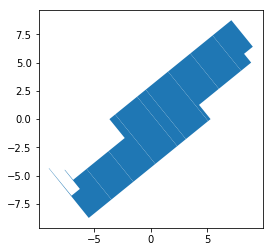

In [18]:
# check
l = glob.glob('json/1091/*.json')
file = random.choice(l)
gdf = gpd.read_file(file, driver="GeoJSON")
gdf.plot()

In [7]:
mio.write_tab(gdf, 'levels.tab')

11 rows of type MultiPolygon written to mapinfo file.


C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
